
🔍 PMC1064074_table_0.jpg


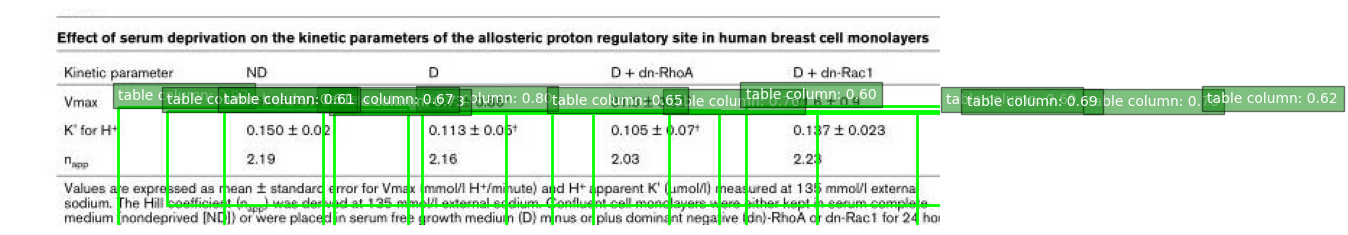


🔍 PMC1064076_table_0.jpg


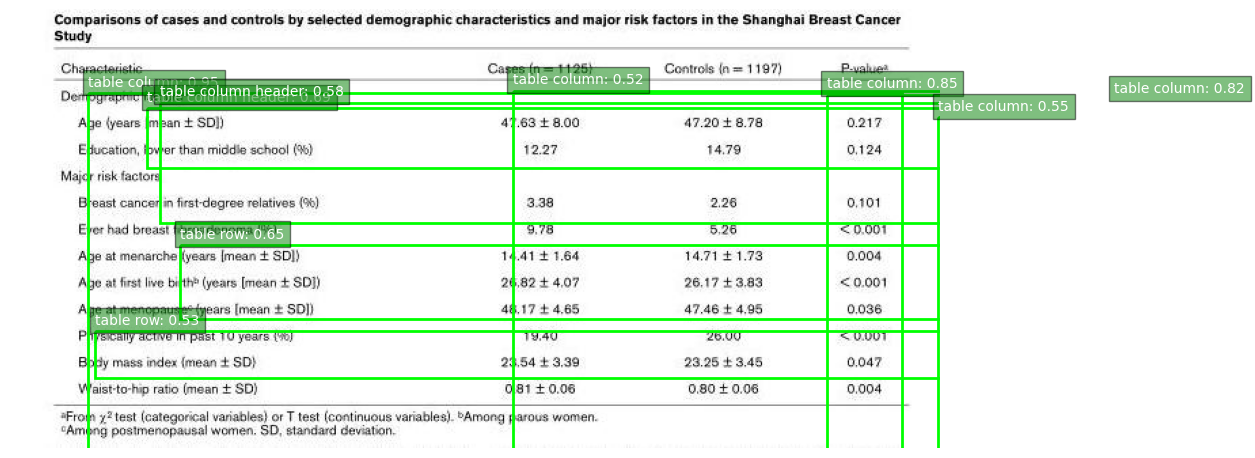


🔍 PMC1064076_table_1.jpg


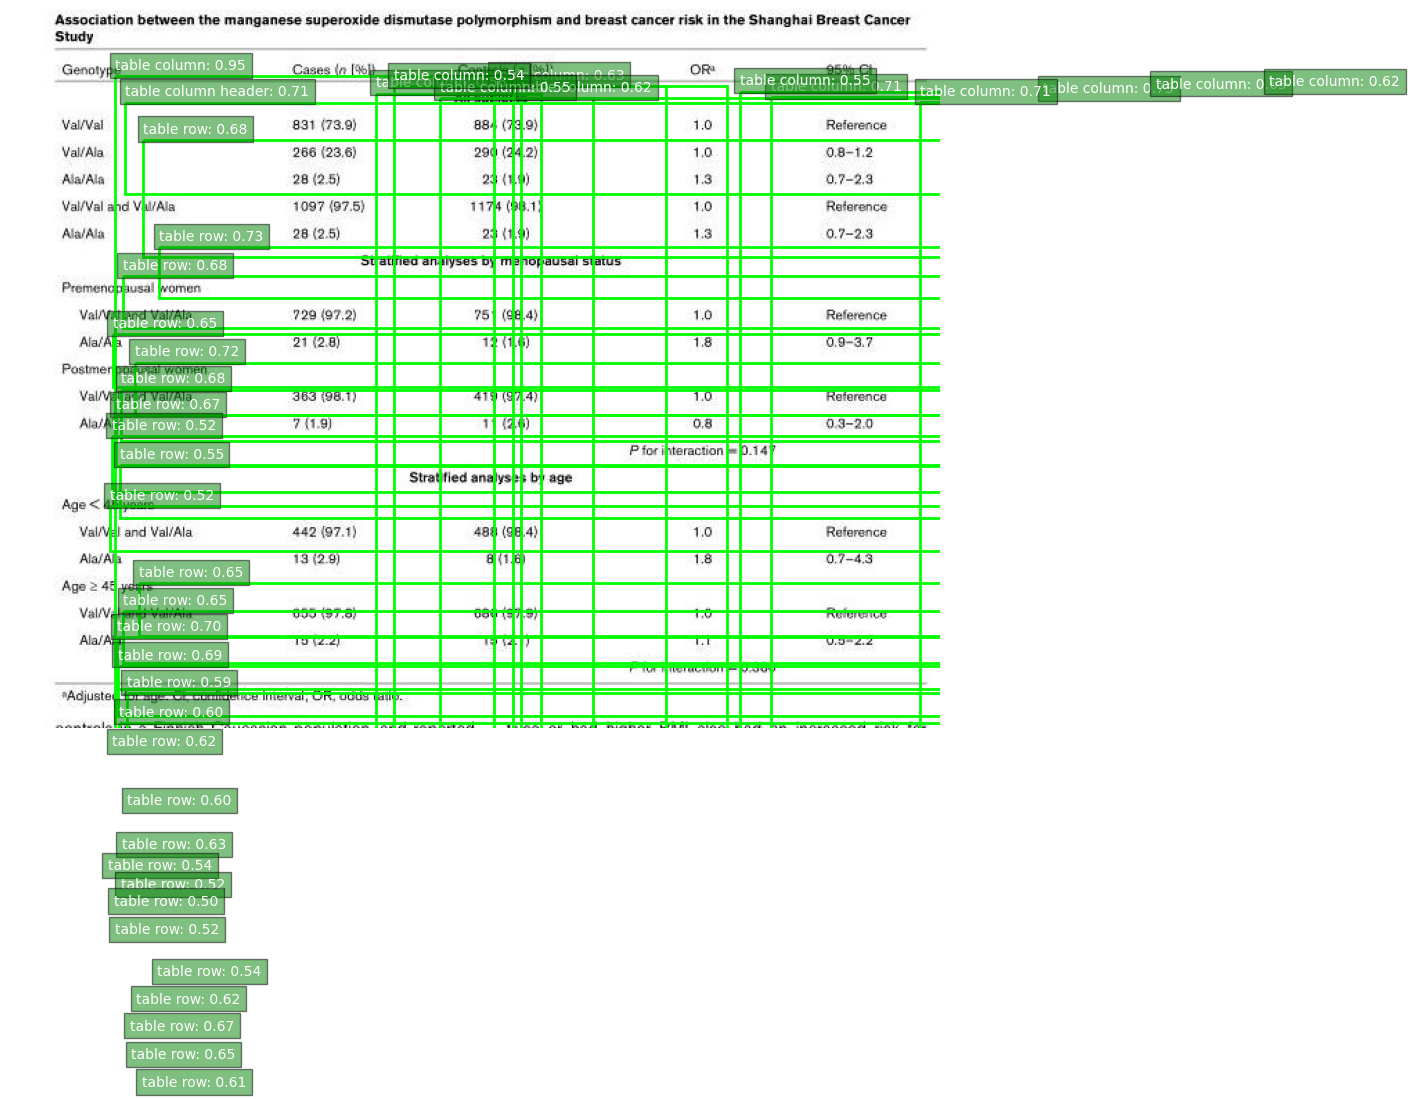


🔍 PMC1064076_table_2.jpg


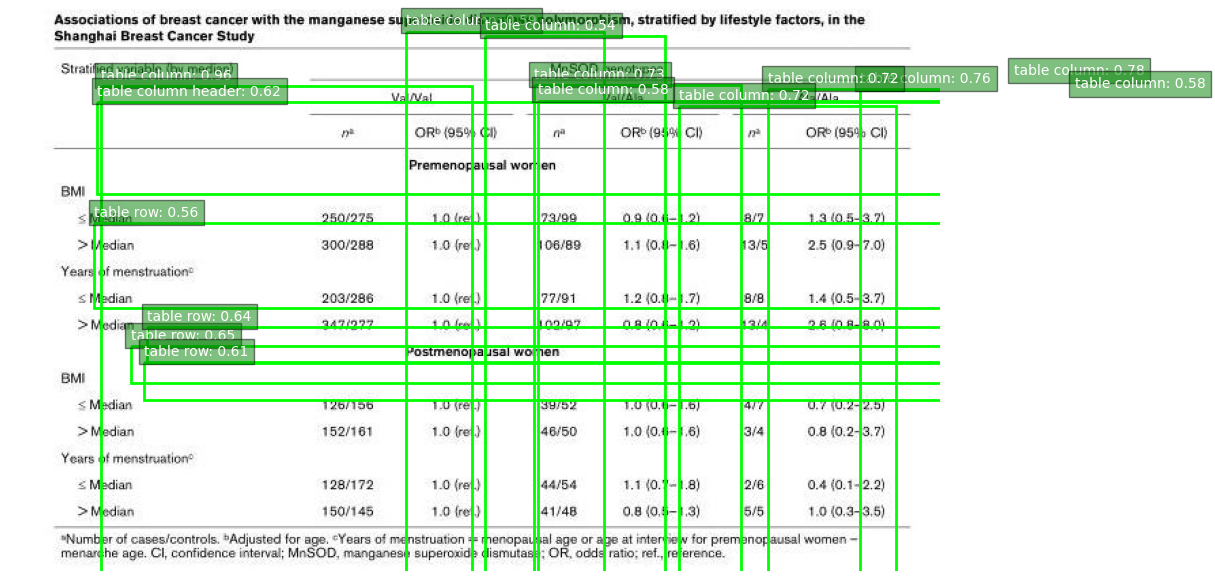


🔍 PMC1064076_table_3.jpg


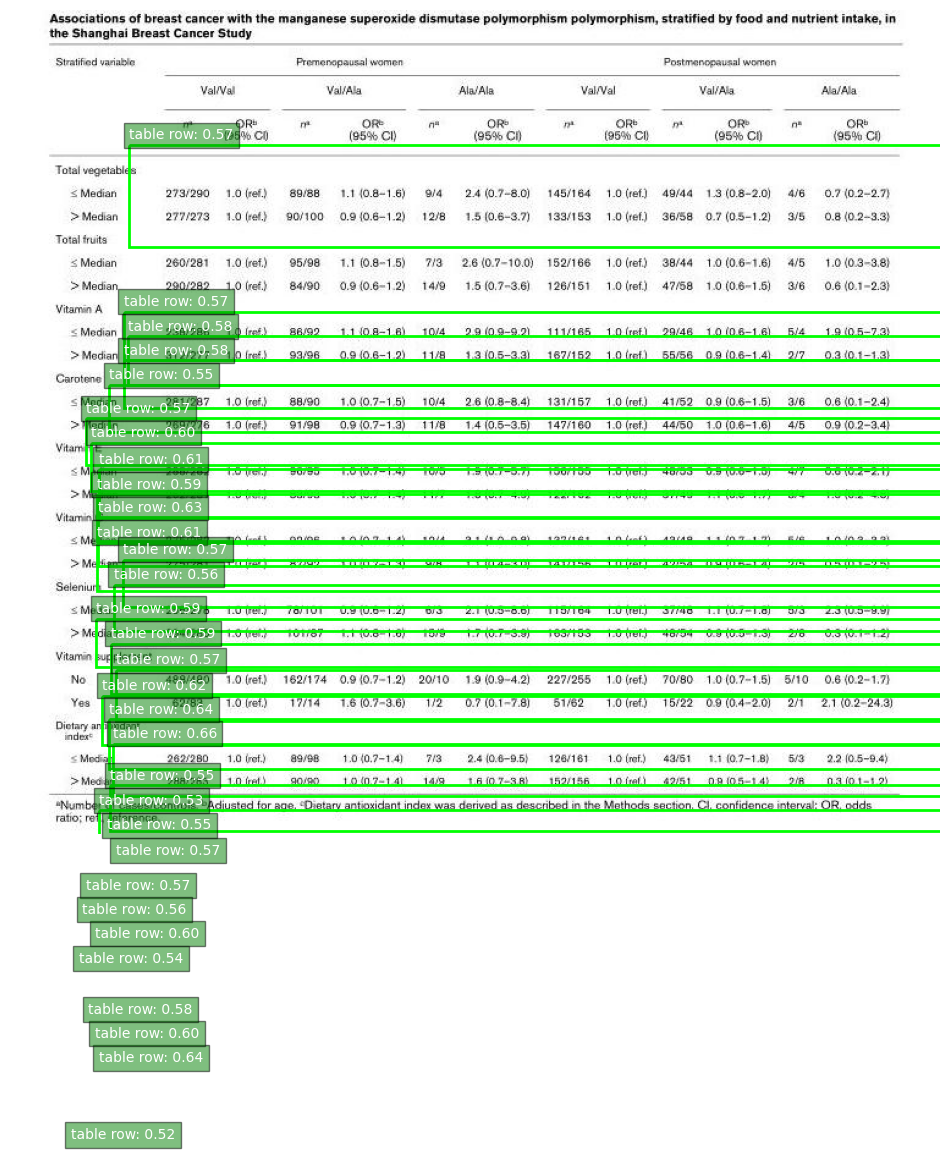


🔍 prices1.jpg


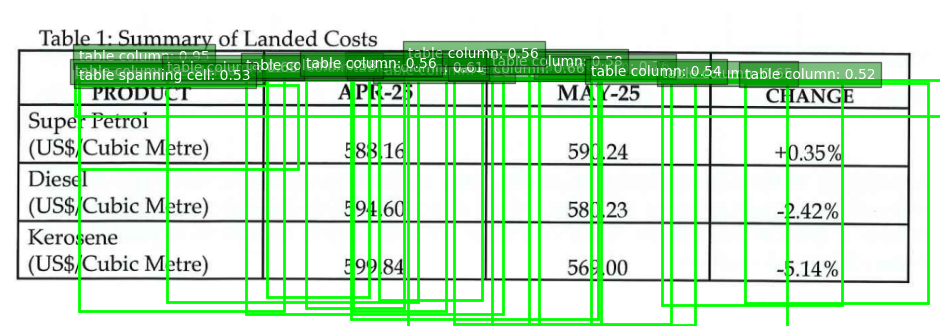


🔍 prices2.jpg


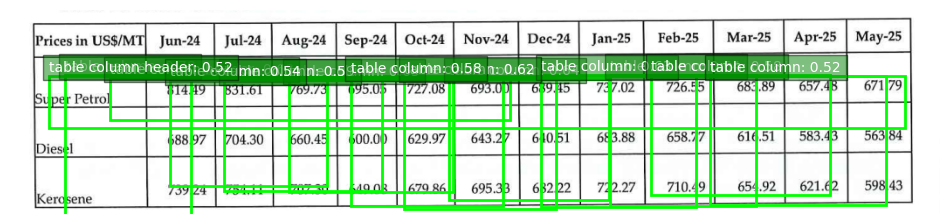


🔍 prices3.jpg


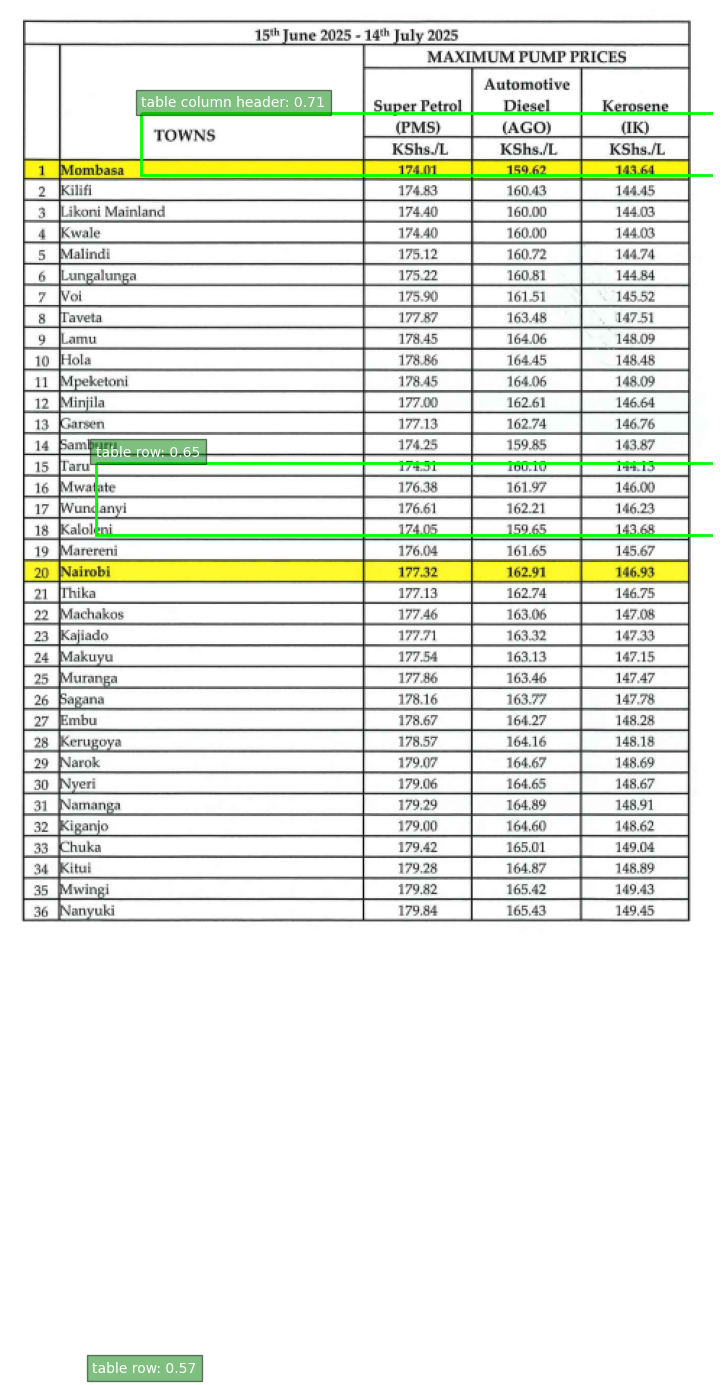


🔍 prices4.jpg


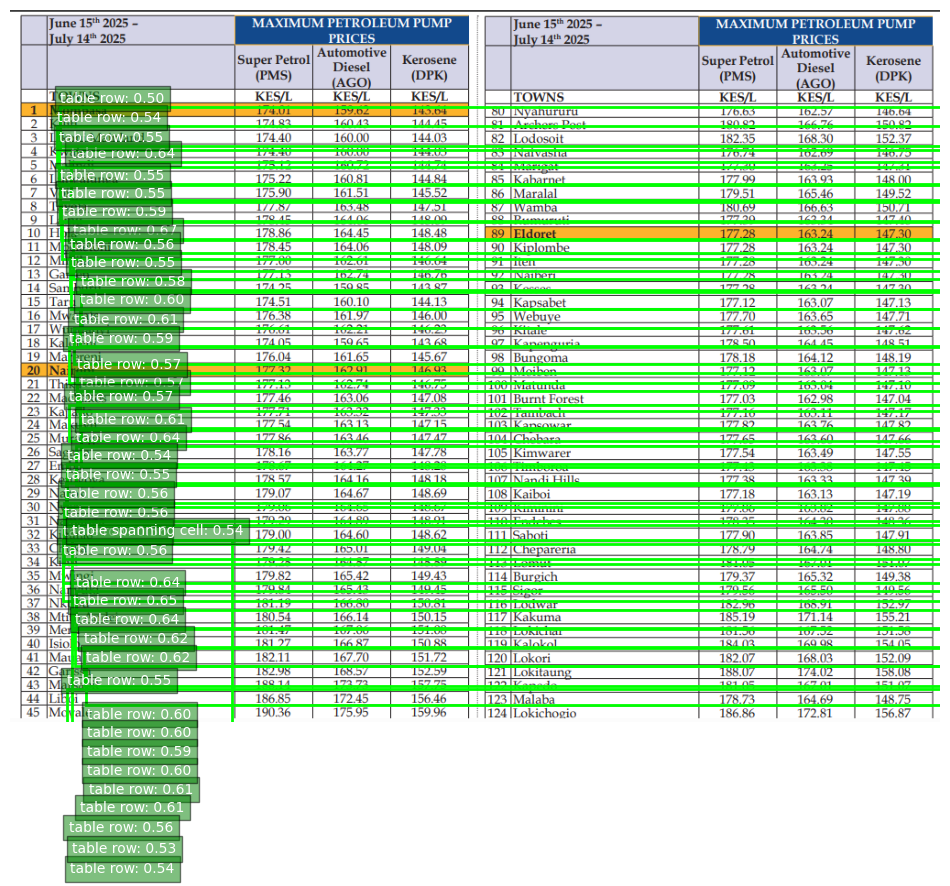

In [10]:
import torch
from torchvision import transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F

label_map = {
    "table": 0,
    "table row": 1,
    "table column": 2,
    "column header": 3,
    "projected row header": 4,
    "spanning cell": 5,
    "no cell": 6,
    "table spanning cell": 7,
    "table column header": 8,
    "table projected column header": 9,
}


# 🔁 Inference transform (if used in training, keep consistent)
inference_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

# 📁 Folder with test images
test_dir = Path("sample_images")

# 🔄 Prediction Function
def predict(image_path, model, device="cuda" if torch.cuda.is_available() else "cpu"):
    image = Image.open(image_path).convert("RGB")
    input_tensor = inference_transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)[0]
    return image, outputs

# 🖼️ Visualizer
def visualize_predictions(image, preds, threshold=0.5, label_map_inv=None):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(image)

    boxes = preds["boxes"].cpu()
    scores = preds["scores"].cpu()
    labels = preds["labels"].cpu()

    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box.tolist()
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=2,
                edgecolor="lime",
                facecolor="none"
            )
            ax.add_patch(rect)
            caption = label_map_inv[label.item()] if label_map_inv else str(label.item())
            ax.text(xmin, ymin - 5, f"{caption}: {score:.2f}", color="white",
                    bbox=dict(facecolor="green", alpha=0.5), fontsize=10)

    plt.axis("off")
    plt.show()

# 📦 Invert label_map if available
label_map_inv = {v: k for k, v in label_map.items()} if 'label_map' in globals() else None
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 👇 Number of classes = len(label_map)
num_classes = len(label_map)

# 🔄 Recreate the model architecture
model = fasterrcnn_resnet50_fpn(pretrained=False)  # Set pretrained=False when loading from custom weights
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 💾 Load trained weights
checkpoint_path = "final_tsr_model.pth"  # or "best_tsr_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))

# ✅ Send model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# 🚀 Loop through all test images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for img_path in sorted(test_dir.glob("*.jpg")):
    print(f"\n🔍 {img_path.name}")
    image, preds = predict(img_path, model, device)
    visualize_predictions(image, preds, label_map_inv=label_map_inv)
